# Darts

In [1]:
pip install darts

Note: you may need to restart the kernel to use updated packages.

In [2]:
import pandas as pd
import numpy as np

In [3]:
# import the csv file and read the pandas dataframe
df=pd.read_csv('aggregate_trip_duration_date.csv',delimiter=",")
df=pd.DataFrame(df)
df=df.dropna()
df=df.sort_values("date")

In [4]:
df

,date,trip_duration
185,01-01-2014,3404
550,01-01-2015,0
216,01-02-2014,10416
581,01-02-2015,0
244,01-03-2014,21936
...,...,...
488,31-10-2014,0
853,31-10-2015,0
184,31-12-2013,20314
549,31-12-2014,0


In [5]:
print(len(df))
df.tail()

915


,date,trip_duration
488,31-10-2014,0
853,31-10-2015,0
184,31-12-2013,20314
549,31-12-2014,0
914,31-12-2015,194


In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from functools import reduce

from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    RegressionEnsembleModel,
    RegressionModel,
    Theta,
    FFT
)

from darts.metrics import mape, mase
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

C:\Users\TAMOJIT\AppData\Local\Programs\Python\Python310\lib\site-packages\torchmetrics\functional\text\chrf.py:43: UserWarning: Failed to initialize NumPy: module compiled against API version 0x10 but this version of numpy is 0xf (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:77.)
  _EPS_SMOOTHING = tensor(1e-16)


In [7]:
series=TimeSeries.from_dataframe(df, 'date', 'trip_duration', fill_missing_dates=True, freq=None)

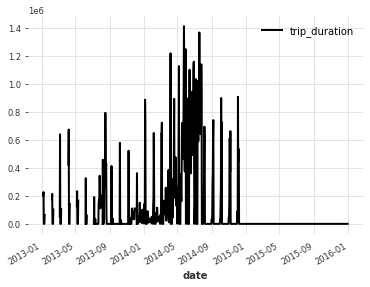

In [8]:
series.plot()

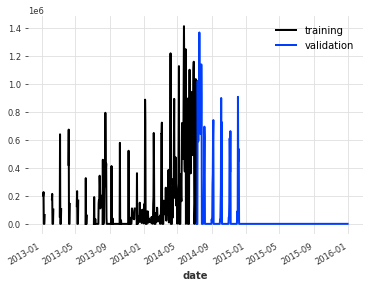

In [9]:
train,val=series.split_before(pd.Timestamp('2014-07-10'))
train.plot(label='training')
val.plot(label='validation')
plt.legend()

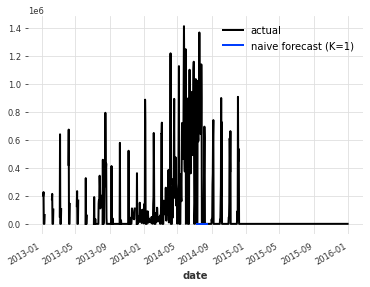

In [10]:
naive_model=NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast=naive_model.predict(36)

series.plot(label='actual')
naive_forecast.plot(label='naive forecast (K=1)')
plt.legend()

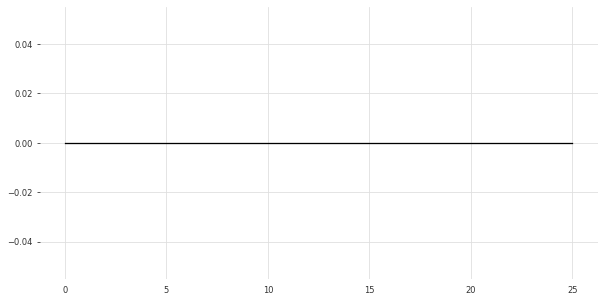

In [11]:
plot_acf(train,m=12,alpha=.05)

In [12]:
for m in range(2,25):
    is_seasonal,period=check_seasonality(train,m=m,alpha=.05)
    if is_seasonal:
        print('There is seasonality of order {}.'.format(period))

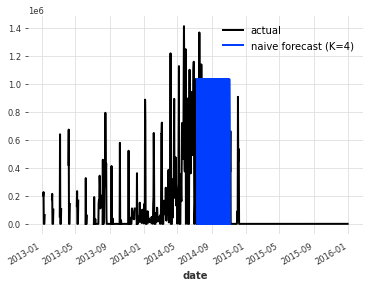

In [13]:
seasonal_model=NaiveSeasonal(K=4)
seasonal_model.fit(train)
seasonal_forecast=seasonal_model.predict(120)

series.plot(label='actual')
seasonal_forecast.plot(label='naive forecast (K=4)')
plt.legend()

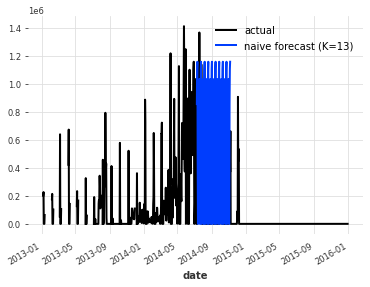

In [14]:
seasonal_model=NaiveSeasonal(K=13)
seasonal_model.fit(train)
seasonal_forecast=seasonal_model.predict(120)

series.plot(label='actual')
seasonal_forecast.plot(label='naive forecast (K=13)')
plt.legend()

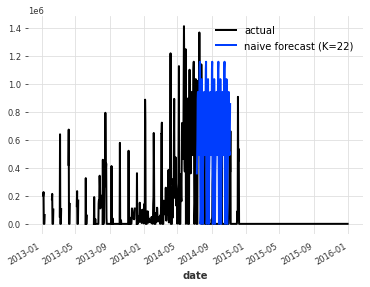

In [15]:
seasonal_model=NaiveSeasonal(K=22)
seasonal_model.fit(train)
seasonal_forecast=seasonal_model.predict(120)

series.plot(label='actual')
seasonal_forecast.plot(label='naive forecast (K=22)')
plt.legend()

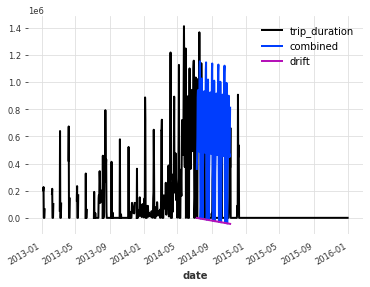

In [16]:
drift_model=NaiveDrift()
drift_model.fit(train)
drift_forecast=drift_model.predict(120)

combined_forecast=drift_forecast+seasonal_forecast-train.last_value()

series.plot()
combined_forecast.plot(label='combined')
drift_forecast.plot(label='drift')
plt.legend()

In [17]:
print("Mean absolute percentage error for the combined naive drift + seasonal: {:.2f}%.".format(mape(series,combined_forecast)))

ValueError: The actual series must be strictly positive to compute the MAPE.

In [ ]:
def eval_model(model):
    model.fit(train)
    forecast=model.predict(len(val))
    print('model {} obtains MAPE: {:.2f}%'.format(model,mape(val,forecast)))
    
eval_model(ExponentialSmoothing())
eval_model(Prophet())
eval_model(AutoARIMA())
eval_model(Theta())

In [ ]:
# seach for the best theta parameter, by trying 50 different values
thetas=2-np.linspace(-10,10,50)

best_mape=float('inf')
best_theta=0

for theta in thetas:
    model=Theta(theta)
    model.fit(train)
    pred_theta=model.predict(len(val))
    res=mape(val,pred_theta)
    
    if res<best_mape:
        best_mape=res
        best_theta=theta

In [ ]:
best_theta_model=Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta=best_theta_model.predict(len(val))

print('The MAPE is: {:.2f}, with theta = {}.'.format(mape(val,pred_best_theta),best_theta))

In [ ]:
train.plot(label='train')
val.plot(label='true')
pred_best_theta.plot(label='prediction')
plt.legend()

In [ ]:
best_theta_model=Theta(best_theta)

average_error=best_theta_model.backtest(series,start=pd.Timestamp('2014-07-10'),forecast_horizon=3,verbose=True)
median_error=best_theta_model.backtest(series,start=pd.Timestamp('2014-07-10'),forecast_horizon=3,reduction=np.median,verbose=true)
print("Average error (MAPE) over all historical forecasts: {}".format(average_error))
print("Median error (MAPE) over all historical forecasts: {}".format(median_error))

raw_errors=best_theta_model.backtest(series,start=pd.Timestamp('2014-07-10'),forecast_horizon=3,reduction=None,verbose=True)
plt.hist(raw_errors,bins=np.arange(0,max(raw_errors),1))
plt.title("Industrial error scores (histogram)")
plt.show()

historical_fcast_theta=nest_theta_model.historical_forecasts(series,start=pd.Timestamp('2014-07-10'),forecast_horizon=3,verbose=True)

In [ ]:
series.plot(label='data')
historical_fcast_theta.plot(label='backtest 3-months ahead forecast (Theta)')
plt.title('MAPE={:.2f}%'.format(mape(historical_fcast_theta,series)))
plt.legend()

In [ ]:
plot_residuals_analysis(best_theta_model.residuals(series))

In [ ]:
model_es=ExponentialSmoothing()
historical_fcast_es=model_es.historical_forecasts(series,start=pd.Timestamp('2014-07-10'),forecast_horizon=3,verbose=True)

series.plot(label='data')
historical_fcast_theta.plot(label='backtest 3-months ahead forecast (Exp. Smoothing)')
plt.title('MAPE={:.2f}%'.format(mape(historical_fcast_es,series)))
plt.legend()
plt.show()

In [ ]:
plot_residuals_analysis(model_es.residuals(series))

In [ ]:
model_es=ExponentialSmoothing()
model_es.fit(train)
probabilistic_forecast=model_es.predict(len(val),num_samples=500)

series.plot(label='actual')
probabilistic_forecast.plot(label='probabilistic forecast')
plt.legend()
plt.show()

In [ ]:
probabilistic_forecast.plot(low_quantile=0.01,high_quantile=0.99,label='1-99th percentiles')
probabilistic_forecast.plot(low_quantile=0.2,high_quantile=0.8,label='20-80th percentiles')

In [ ]:
ensemble_model=RegressionEnsembleModel(
    forecasting_models=[NaiveSeasonal(6),NaiveSeasonal(12),NaiveDrift()],
    regression_train_n_points=12)

ensemble_model.fit(train)
ensemble_pred=ensemble_model.predict(120)

series.plot(label='actual')
ensemble_pred.plot(label='ensemble forecast')
plt.title('MAPE = {:.2f}%'.format(mape(ensemble_pred,series)))
plt.legend()

In [ ]:
ensemble_pred_hist=ensemble_model.historical_forecasts(series,
                                                      start=pd.Timestamp('2014-07-10'),
                                                      forecast_horizon=3,
                                                      verbose=True)
series.plot(label='actual')
ensemble_pred_hist.plot(label='ensemble forecast')
plt.title('Historical forecast: MAPE = {:.2f}%'.format(mape(ensemble_pred_hist,series)))
plt.legend()

### RNN Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality,plot_acf

from darts.utils.timeseries_generation import datetime_attribute_timeseries

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

In [ ]:
# create training and validation sets
train,val=series.split_after(pd.Timestamp('2014-07-10'))

# normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer=Scaler()
train_transformed=transformer.fit_transform(train)
val_transformed=transformer.transform(val)
series_transformed=transformer.transform(series)

# create month and year covariate series
year_series=datetime_attribute_timeseries(pd.date_range(start=series.start_time(),freq=series.freq_str,periods=1000),
                                         attribute='year',one_hot='False')
year_series=Scaler().fit_transform(year_series)
month_series=datetime_attribute_timeseries(year_series,attribute='month',one_hot=True)
covariates=year_series.stack(month_series)
cov_train,cov_val=covariates.split_after(pd.Timestamp('2014-07-10'))

In [ ]:
my_model=RNNModel(
    model='LSTM',
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=100,
    optimizer_kwargs=('lr':1e-3),
    model_name='WPT_RNN',
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=14,
    force_reset=True
)

In [ ]:
my_model.fit(train_transformed,
                future_covariates=covariates,
                val_series=val_transformed,
                val_future_covariates=covariates,
                verbose=True)

In [ ]:
def eval_model(model):
    pred_series=model.predict(n=26,future_covariates=covariates)
    plt.figure(figsize=(8,5))
    series_transformed.plot(label='actual')
    pred_series.plot(label='forecast')
    plt.title('MAPE: {:.2f}%'.format(mape(pred_series,val_transformed)))
    plt.legend()
    
eval_model(my_model)

In [ ]:
best_model=RNNModel.load_from_checkpoint(model_name='WPT_RNN',best=True)
eval_model(best_model)

In [ ]:
backtest_series=my_model.historical_forecasts(series_transformed,
                                             future_covariates=covariates,
                                             start=pd.Timestamp('2014-07-10'),
                                             forecast_horizon=6,
                                             retrain=False,
                                             verbose=True)

In [ ]:
plt.figure(figsize=(8,5))
series_transformed.plot(label='actual')
backtest_series.plot(label='backtest')
plt.legend()
plt.title('Backtest starting July 2014, 6-month horizon')
print('MAPE: {:.2f}%'.format(mape(transformer.inverse_transform(series_transformed),
                                 transformer.inverse_transform(backtest_series))))